In [2]:
# from google.colab import files
# uploaded = files.upload()  # Upload your dataset2.zip


In [1]:
# !pip install librosa
# !pip install lxml


In [3]:
import os
import librosa
import numpy as np
from lxml import etree

audio_features = []
xml_targets = []

def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    log_mel = librosa.power_to_db(mel)
    return log_mel.T  # Time x Features

def parse_xml(xml_path):
    tree = etree.parse(xml_path)
    root = tree.getroot()
    events = []

    for event in root.findall(".//event"):
        pitch = int(event.findtext("pitch"))
        onset = float(event.findtext("onsetSec"))
        offset = float(event.findtext("offsetSec"))
        excitation = event.findtext("excitationStyle")
        expression = event.findtext("expressionStyle")

        events.append({
            "pitch": pitch,
            "onset": onset,
            "offset": offset,
            "excitation": excitation,
            "expression": expression
        })
    return events

# Update this path after extraction
base_audio = '/content/drive/MyDrive/dataset2/audio'
base_xml = '/content/drive/MyDrive/dataset2/annotation'

for root_dir, _, files in os.walk(base_audio):
    for file in files:
        if file.endswith(".wav"):
            audio_path = os.path.join(root_dir, file)
            xml_path = audio_path.replace('audio', 'annotation').replace('.wav', '.xml')

            if not os.path.exists(xml_path):
                print(f"⚠️ Missing XML for {file}")
                continue

            # Extract features & labels
            try:
                features = extract_features(audio_path)
                labels = parse_xml(xml_path)

                audio_features.append(features)
                xml_targets.append(labels)

            except Exception as e:
                print(f"Error processing {file}: {e}")


⚠️ Missing XML for AR_Lick11_FN.wav
⚠️ Missing XML for AR_Lick11_KN.wav
⚠️ Missing XML for AR_Lick11_MN.wav
⚠️ Missing XML for FS_Lick11_FN.wav
⚠️ Missing XML for FS_Lick11_KN.wav
⚠️ Missing XML for FS_Lick11_MN.wav
⚠️ Missing XML for LP_Lick11_FN.wav
⚠️ Missing XML for LP_Lick11_MN.wav
⚠️ Missing XML for LP_Lick11_KN.wav


In [4]:
audio_features

[array([[-47.962597, -47.962597, -47.962597, ..., -47.962597, -47.962597,
         -47.962597],
        [-47.962597, -47.962597, -47.962597, ..., -47.962597, -47.962597,
         -47.962597],
        [-47.962597, -47.962597, -47.962597, ..., -47.962597, -47.962597,
         -47.962597],
        ...,
        [-32.848927, -47.962597, -47.962597, ..., -47.962597, -47.962597,
         -47.962597],
        [-32.667454, -47.962597, -47.962597, ..., -47.962597, -47.962597,
         -47.962597],
        [-32.909485, -47.962597, -47.962597, ..., -47.962597, -47.962597,
         -47.962597]], dtype=float32),
 array([[-58.40069 , -58.40069 , -58.40069 , ..., -58.40069 , -58.40069 ,
         -58.40069 ],
        [-58.40069 , -58.40069 , -58.40069 , ..., -58.40069 , -58.40069 ,
         -58.40069 ],
        [-58.40069 , -58.40069 , -58.40069 , ..., -58.40069 , -58.40069 ,
         -58.40069 ],
        ...,
        [-57.567543, -58.40069 , -58.40069 , ..., -58.40069 , -58.40069 ,
         -58.40069 

In [5]:
xml_targets

[[{'pitch': 45,
   'onset': 1.579,
   'offset': 2.2409,
   'excitation': 'PK',
   'expression': 'NO'},
  {'pitch': 46,
   'onset': 2.6026,
   'offset': 3.3066,
   'excitation': 'PK',
   'expression': 'NO'},
  {'pitch': 47,
   'onset': 3.6949,
   'offset': 4.397,
   'excitation': 'PK',
   'expression': 'NO'},
  {'pitch': 48,
   'onset': 4.7456,
   'offset': 5.4846,
   'excitation': 'PK',
   'expression': 'NO'},
  {'pitch': 49,
   'onset': 5.8514,
   'offset': 6.5035,
   'excitation': 'PK',
   'expression': 'NO'},
  {'pitch': 50,
   'onset': 6.9486,
   'offset': 7.602,
   'excitation': 'PK',
   'expression': 'NO'},
  {'pitch': 51,
   'onset': 7.9819,
   'offset': 8.6676,
   'excitation': 'PK',
   'expression': 'NO'},
  {'pitch': 52,
   'onset': 9.0266,
   'offset': 9.7444,
   'excitation': 'PK',
   'expression': 'NO'},
  {'pitch': 53,
   'onset': 10.0785,
   'offset': 10.7222,
   'excitation': 'PK',
   'expression': 'NO'},
  {'pitch': 54,
   'onset': 11.0685,
   'offset': 11.7091,
   'ex

In [ ]:
# !pip install tensorflow

In [6]:
import tensorflow
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_audio_len = 2000  # adjust based on your longest sequence
max_events = 50       # max XML events per file

# Collect values for encoding
all_pitches = []
all_excitations = []
all_expressions = []

for label_set in xml_targets:
    for event in label_set:
        all_pitches.append(event["pitch"])
        all_excitations.append(event["excitation"])
        all_expressions.append(event["expression"])

# Encode non-numeric labels
excitation_encoder = LabelEncoder()
expression_encoder = LabelEncoder()

excitation_encoder.fit(all_excitations)
expression_encoder.fit(all_expressions)

def encode_label_set(events):
    encoded = []
    for e in events[:max_events]:
        encoded.append([
            e["pitch"],
            e["onset"],
            e["offset"],
            excitation_encoder.transform([e["excitation"]])[0],
            expression_encoder.transform([e["expression"]])[0]
        ])
    return encoded

# Pad Mel spectrograms
padded_features = pad_sequences(audio_features, maxlen=max_audio_len, dtype='float32', padding='post', truncating='post')

# Pad label sequences
encoded_labels = [encode_label_set(events) for events in xml_targets]
padded_labels = pad_sequences(encoded_labels, maxlen=max_events, dtype='float32', padding='post', truncating='post')

print("✅ Feature shape:", padded_features.shape)
print("✅ Label shape:", padded_labels.shape)


✅ Feature shape: (252, 2000, 64)
✅ Label shape: (252, 50, 5)


In [13]:
import librosa
import numpy as np

def extract_features(audio_path, sr=16000, n_mfcc=64, max_len=2000):
    y, _ = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T  # shape: (T, 64)

    # Pad or truncate to fixed length
    if mfcc.shape[0] < max_len:
        pad_width = max_len - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:max_len]

    return mfcc  # shape: (2000, 64)


In [16]:
features = extract_features(audio_path)       # (2000, 64)
features = np.expand_dims(features, axis=0)   # (1, 2000, 64)


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed, Attention, Dropout

input_shape = padded_features.shape[1:]  # (2000, 64)
output_dim = padded_labels.shape[1:]     # (50, 5)

# Input
inputs = Input(shape=input_shape)  # (T=2000, 64)

# BiLSTM Layers
x = Bidirectional(LSTM(256, return_sequences=True))(inputs)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)


# Context Summary
context_vector = tf.keras.layers.GlobalAveragePooling1D()(x)  # Shape: (batch, features)
context_repeated = tf.keras.layers.RepeatVector(output_dim[0])(context_vector)

# Decode each note
decoder = LSTM(64, return_sequences=True)(context_repeated)
outputs = TimeDistributed(Dense(5))(decoder)  # 5 = pitch, onset, offset, excitation, expression

# Build model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 2000, 512)           │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2000, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 2000, 128)           │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2000, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 2000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 50, 5)               │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,101,381 (4.20 MB)

 Trainable params: 1,101,381 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    x=padded_features,
    y=padded_labels,
    epochs=15,
    batch_size=32,
    validation_split=0.3
)


Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 170s 26s/step - loss: 226.8132 - mae: 5.0693 - val_loss: 206.2466 - val_mae: 5.6462
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 198s 25s/step - loss: 207.6751 - mae: 5.7409 - val_loss: 191.5352 - val_mae: 5.8237
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 203s 26s/step - loss: 193.4395 - mae: 5.8896 - val_loss: 181.1056 - val_mae: 5.9197
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 195s 24s/step - loss: 175.8661 - mae: 5.8500 - val_loss: 175.0363 - val_mae: 6.0425
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 208s 25s/step - loss: 176.7529 - mae: 6.1041 - val_loss: 171.5826 - val_mae: 6.1153
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 199s 25s/step - loss: 179.8760 - mae: 6.3021 - val_loss: 169.5567 - val_mae: 6.1719
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 201s 25s/step - loss: 181.8576 - mae: 6.4803 - val_loss: 168.1221 - val_mae: 6.2290
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 205s 26s/step - loss: 165.3945 - mae: 6.1914 - val_loss: 166.9804 - val_mae: 6.2754
Epoch 9/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 199s

In [17]:
def predict_tab(audio_path, model):
    features = extract_features(audio_path)
    features = np.expand_dims(features, axis=0)  # (1, 2000, 64)
    prediction = model.predict(features)[0]      # (50, 5)

    return prediction


In [19]:
prediction = model.predict(features)[0]  # shape: (50, 5)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[ 0.01890747  0.02757351  0.00611923 -0.01700141  0.04607751]
 [ 0.03363922  0.04620182  0.0061591  -0.02913354  0.0749609 ]
 [ 0.04558669  0.05910493  0.00318177 -0.03720443  0.09223264]
 [ 0.05551828  0.06832645 -0.00102074 -0.04208053  0.10178372]
 [ 0.06386837  0.07515341 -0.00545628 -0.04456554  0.10630225]
 [ 0.0709032   0.08038997 -0.00961882 -0.0453444   0.10763235]
 [ 0.07680915  0.08453561 -0.01328685 -0.04496827  0.10702775]
 [ 0.0817356   0.0879005  -0.01639763 -0.0438619   0.10532973]
 [ 0.08581384  0.09067912 -0.018971   -0.04234034  0.10309261]
 [ 0.08916388  0.09299675 -0.02106474 -0.04062878  0.10067175]
 [ 0.0918958   0.09493776 -0.02274933 -0.0388815   0.09828599]
 [ 0.0941095   0.09656279 -0.02409483 -0.03719886  0.09606151]
 [ 0.09589368  0.0979185  -0.02516442 -0.03564113  0.09406283]
 [ 0.0973258   0.09904336 -0.02601228 -0.03423997  0.09231462]
 [ 0.09847213  0.09997036 -0.02668304 -0.03300713  0.09081646]
 [ 0.09938823  0.10

In [ ]:
# import os
# import xml.etree.ElementTree as ET

# def get_unique_pitches(annotation_dir):
#     pitch_set = set()
#     for filename in os.listdir(annotation_dir):
#         if filename.endswith('.xml'):
#             filepath = os.path.join(annotation_dir, filename)
#             tree = ET.parse(filepath)
#             root = tree.getroot()
#             for event in root.findall(".//event"):
#                 pitch = int(event.find("pitch").text)
#                 pitch_set.add(pitch)
#     return sorted(list(pitch_set))

# annotation_path = "/content/drive/MyDrive/dataset2/annotation"  # Update if different
# unique_pitches = get_unique_pitches(annotation_path)
# num_pitches = len(unique_pitches)


In [ ]:
# import os
# import xml.etree.ElementTree as ET

# def extract_unique_classes(annotation_dir):
#     pitch_set = set()
#     excitation_set = set()
#     expression_set = set()

#     for filename in os.listdir(annotation_dir):
#         if filename.endswith('.xml'):
#             filepath = os.path.join(annotation_dir, filename)
#             tree = ET.parse(filepath)
#             root = tree.getroot()
#             for event in root.findall(".//event"):
#                 # Pitch
#                 pitch = event.find("pitch")
#                 if pitch is not None:
#                     pitch_set.add(int(pitch.text))

#                 # Excitation
#                 excitation = event.find("excitationStyle")
#                 if excitation is not None:
#                     excitation_set.add(excitation.text.strip())

#                 # Expression
#                 expression = event.find("expressionStyle")
#                 if expression is not None:
#                     expression_set.add(expression.text.strip())

#     return (
#         sorted(pitch_set),
#         sorted(excitation_set),
#         sorted(expression_set)
#     )

# annotation_dir = "/content/drive/MyDrive/dataset2/annotation"

# unique_pitches, unique_excitations, unique_expressions = extract_unique_classes(annotation_dir)

# num_pitches = len(unique_pitches)
# num_excitation_classes = len(unique_excitations)
# num_expression_classes = len(unique_expressions)

# print("Pitches:", num_pitches)
# print("Excitation Classes:", num_excitation_classes)
# print("Expression Classes:", num_expression_classes)


Pitches: 48
Excitation Classes: 3
Expression Classes: 6


In [ ]:
## For Some Modifications  --

In [ ]:
# from tensorflow.keras import Input, Model
# from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Bidirectional

# input_layer = Input(shape=(2000, 64))  # shape of audio features

# x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
# x = Bidirectional(LSTM(128, return_sequences=True))(x)

# # Shared representation
# shared = TimeDistributed(Dense(64, activation='relu'))(x)

# # Branches for outputs
# pitch_out = TimeDistributed(Dense(num_pitches, activation='softmax'), name="pitch")(shared)
# onset_out  = TimeDistributed(Dense(1, activation='linear'), name="onset")(shared)
# offset_out = TimeDistributed(Dense(1, activation='linear'), name="offset")(shared)
# excite_out = TimeDistributed(Dense(num_excitation_classes, activation='softmax'), name="excitation")(shared)
# express_out = TimeDistributed(Dense(num_expression_classes, activation='softmax'), name="expression")(shared)

# model = Model(inputs=input_layer, outputs=[pitch_out, onset_out, offset_out, excite_out, express_out])


In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss={
        "pitch": "sparse_categorical_crossentropy",
        "onset": "mse",
        "offset": "mse",
        "excitation": "sparse_categorical_crossentropy",
        "expression": "sparse_categorical_crossentropy"
    },
    metrics={
        "pitch": "sparse_categorical_accuracy",
        "onset": "mae",
        "offset": "mae",
        "excitation": "sparse_categorical_accuracy",
        "expression": "sparse_categorical_accuracy"
    }
)


In [ ]:
# model.fit(
#     x_train,
#     {
#         "pitch": y_pitch,
#         "onset": y_onset,
#         "offset": y_offset,
#         "excitation": y_excite,
#         "expression": y_express
#     },
#     validation_data=(x_val, {
#         "pitch": y_val_pitch,
#         "onset": y_val_onset,
#         "offset": y_val_offset,
#         "excitation": y_val_excite,
#         "expression": y_val_express
#     }),
#     epochs=30,
#     batch_size=16
# )


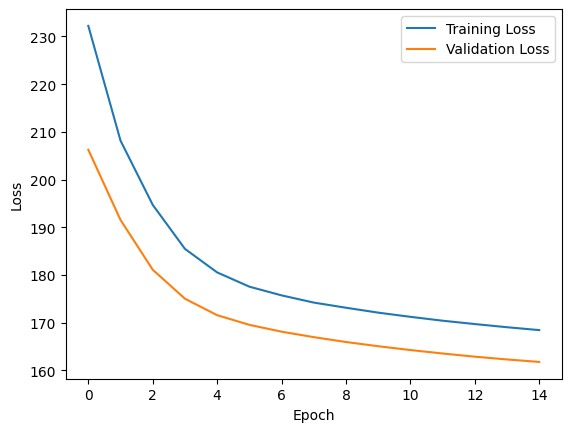

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

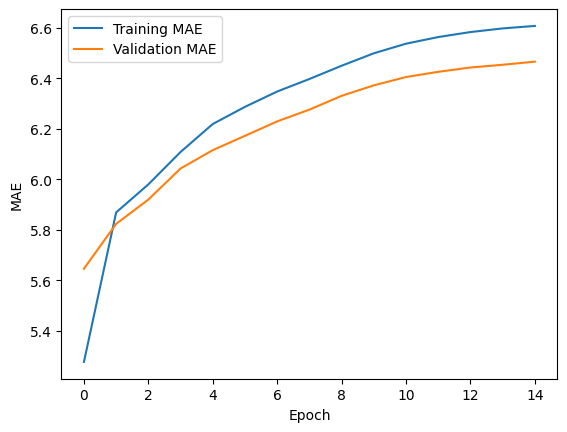

In [21]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [22]:
import numpy as np

def tolerance_accuracy(y_true, y_pred, tolerance=0.5):
    # Absolute difference across all values
    diff = np.abs(y_true - y_pred)

    # Check if all values per note are within the tolerance
    correct_per_note = np.all(diff <= tolerance, axis=-1)

    # Count how many notes (out of total) are fully correct
    return np.mean(correct_per_note)


In [23]:
val_preds = model.predict(padded_features)
acc = tolerance_accuracy(padded_labels, val_preds, tolerance=0.2)
print(f"Tolerant accuracy: {acc:.2%}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step
Tolerant accuracy: 65.44%


In [24]:
test_index = 0  # or any index
test_input = padded_features[test_index:test_index+1]  # shape: (1, 2000, 64)
true_output = padded_labels[test_index]  # shape: (50, 5)


In [25]:
true_output

array([[45.    ,  1.579 ,  2.2409,  2.    ,  3.    ],
       [46.    ,  2.6026,  3.3066,  2.    ,  3.    ],
       [47.    ,  3.6949,  4.397 ,  2.    ,  3.    ],
       [48.    ,  4.7456,  5.4846,  2.    ,  3.    ],
       [49.    ,  5.8514,  6.5035,  2.    ,  3.    ],
       [50.    ,  6.9486,  7.602 ,  2.    ,  3.    ],
       [51.    ,  7.9819,  8.6676,  2.    ,  3.    ],
       [52.    ,  9.0266,  9.7444,  2.    ,  3.    ],
       [53.    , 10.0785, 10.7222,  2.    ,  3.    ],
       [54.    , 11.0685, 11.7091,  2.    ,  3.    ],
       [55.    , 12.1367, 12.8534,  2.    ,  3.    ],
       [56.    , 13.153 , 13.7641,  2.    ,  3.    ],
       [57.    , 14.1674, 14.7976,  2.    ,  3.    ],
       [58.    , 15.2083, 15.7609,  2.    ,  3.    ],
       [59.    , 16.2364, 16.8388,  2.    ,  3.    ],
       [60.    , 17.2512, 17.8663,  2.    ,  3.    ],
       [61.    , 18.2692, 18.8666,  2.    ,  3.    ],
       [62.    , 19.3056, 19.8654,  2.    ,  3.    ],
       [63.    , 20.2904, 20

In [26]:
predicted_output = model.predict(test_input)[0]  # shape: (50, 5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [27]:
test_input

array([[[-47.962597, -47.962597, -47.962597, ..., -47.962597,
         -47.962597, -47.962597],
        [-47.962597, -47.962597, -47.962597, ..., -47.962597,
         -47.962597, -47.962597],
        [-47.962597, -47.962597, -47.962597, ..., -47.962597,
         -47.962597, -47.962597],
        ...,
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ]]], dtype=float32)

In [28]:
# Round pitch, excitation, expression if they are supposed to be discrete
rounded_pred = predicted_output.copy()
rounded_pred[:, 0] = np.round(predicted_output[:, 0])  # pitch
rounded_pred[:, 3] = np.round(predicted_output[:, 3])  # excitation
rounded_pred[:, 4] = np.round(predicted_output[:, 4])  # expression


In [29]:
rounded_pred

array([[ 0.        , -0.00853866,  0.0018211 ,  0.        ,  0.        ],
       [ 0.        , -0.01203367,  0.00314088,  0.        ,  0.        ],
       [ 0.        , -0.01227175,  0.00396113,  0.        ,  0.        ],
       [ 0.        , -0.01044741,  0.00419523,  0.        ,  0.        ],
       [ 0.        , -0.00739006,  0.00378723,  0.        ,  0.        ],
       [ 0.        , -0.00368352,  0.00274565,  0.        , -0.        ],
       [ 0.        ,  0.00026562,  0.00113831,  0.        , -0.        ],
       [ 0.        ,  0.00418249, -0.00092693,  0.        , -0.        ],
       [ 0.        ,  0.00789043, -0.00332328,  0.        , -0.        ],
       [ 0.        ,  0.01128493, -0.00592245,  0.        , -0.        ],
       [ 0.        ,  0.01431346, -0.00860665,  0.        , -0.        ],
       [ 0.        ,  0.01695977, -0.01127572,  0.        , -0.        ],
       [ 0.        ,  0.01923197, -0.01385028,  0.        , -0.        ],
       [ 0.        ,  0.02115355, -0.0

In [30]:
import pandas as pd

# For better readability
df_true = pd.DataFrame(true_output, columns=["Pitch", "Onset", "Offset", "Excitation", "Expression"])
df_pred = pd.DataFrame(rounded_pred, columns=["Pitch", "Onset", "Offset", "Excitation", "Expression"])

# Show side by side
comparison = pd.concat([df_true, df_pred], axis=1, keys=["Ground Truth", "Prediction"])
print(comparison.head(10))  # Check first 10 notes


  Ground Truth                                         Prediction            \
         Pitch    Onset   Offset Excitation Expression      Pitch     Onset   
0         45.0   1.5790   2.2409        2.0        3.0        0.0 -0.008539   
1         46.0   2.6026   3.3066        2.0        3.0        0.0 -0.012034   
2         47.0   3.6949   4.3970        2.0        3.0        0.0 -0.012272   
3         48.0   4.7456   5.4846        2.0        3.0        0.0 -0.010447   
4         49.0   5.8514   6.5035        2.0        3.0        0.0 -0.007390   
5         50.0   6.9486   7.6020        2.0        3.0        0.0 -0.003684   
6         51.0   7.9819   8.6676        2.0        3.0        0.0  0.000266   
7         52.0   9.0266   9.7444        2.0        3.0        0.0  0.004182   
8         53.0  10.0785  10.7222        2.0        3.0        0.0  0.007890   
9         54.0  11.0685  11.7091        2.0        3.0        0.0  0.011285   

                                   
     Offset Exc

In [31]:
comparison.head(5)

Ground Truth                                       Prediction            \
         Pitch   Onset  Offset Excitation Expression      Pitch     Onset   
0         45.0  1.5790  2.2409        2.0        3.0        0.0 -0.008539   
1         46.0  2.6026  3.3066        2.0        3.0        0.0 -0.012034   
2         47.0  3.6949  4.3970        2.0        3.0        0.0 -0.012272   
3         48.0  4.7456  5.4846        2.0        3.0        0.0 -0.010447   
4         49.0  5.8514  6.5035        2.0        3.0        0.0 -0.007390   

                                   
     Offset Excitation Expression  
0  0.001821        0.0        0.0  
1  0.003141        0.0        0.0  
2  0.003961        0.0        0.0  
3  0.004195        0.0        0.0  
4  0.003787        0.0        0.0

In [32]:
# # Custom tolerance accuracy on pitch
# pitch_accuracy = np.mean(np.abs(df_true["Pitch"] - df_pred["Pitch"]) < 2)
# print(f"Pitch Accuracy within ±2: {pitch_accuracy:.2%}")


In [33]:
# Map of string to its open MIDI note
GUITAR_STRINGS = {
    'E': 40,  # Low E (String 6)
    'A': 45,
    'D': 50,
    'G': 55,
    'B': 59,
    'e': 64   # High E (String 1)
}


In [34]:
tab_lines = {
    'e': ['-'] * 50,
    'B': ['-'] * 50,
    'G': ['-'] * 50,
    'D': ['-'] * 50,
    'A': ['-'] * 50,
    'E': ['-'] * 50,
}


In [35]:
def prediction_to_tab(prediction):
    GUITAR_STRINGS = {
        'E': 40,  # low E
        'A': 45,
        'D': 50,
        'G': 55,
        'B': 59,
        'e': 64   # high E
    }

    tab_lines = {string: ['-'] * len(prediction) for string in GUITAR_STRINGS.keys()}

    for i, note in enumerate(prediction):
        pitch = int(round(note[0]))
        best_string = None
        best_fret = 100  # arbitrarily high to find min

        for string, open_pitch in GUITAR_STRINGS.items():
            fret = pitch - open_pitch
            if 0 <= fret < best_fret and fret <= 24:
                best_string = string
                best_fret = fret

        if best_string:
            tab_lines[best_string][i] = str(best_fret)

    tab_output = ''
    for string in ['e', 'B', 'G', 'D', 'A', 'E']:
        tab_output += f"{string}|" + ''.join(tab_lines[string]) + "|\n"

    return tab_output


In [36]:
def predict_tab(audio_path, model):
    features = extract_features(audio_path)  # → shape (2000, 64)
    features = np.expand_dims(features, axis=0)
    prediction = model.predict(features)[0]  # → shape (50, 5)

    ascii_tab = prediction_to_tab(prediction)
    return ascii_tab


In [38]:
ascii_tab = predict_tab("/content/drive/MyDrive/dataset2/audio/AR_Lick11_KN.wav", model)
print(ascii_tab)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
e|--------------------------------------------------|
B|--------------------------------------------------|
G|--------------------------------------------------|
D|--------------------------------------------------|
A|--------------------------------------------------|
E|--------------------------------------------------|

